# 🐱🐶 Sistema de Segmentação Modular - Cats vs Dogs

Este notebook implementa um sistema **modular e profissional** de segmentação semântica para identificar gatos e cachorros em imagens, utilizando arquitetura U-Net otimizada.

## 🏗️ **Arquitetura Modular:**

### 📁 **Classe DataManager**
- Carregamento robusto e consistente de dados
- Validação automática de correspondência imagem-máscara
- Preprocessamento padronizado e normalização
- Suporte a múltiplas classes (gatos, cachorros, background)

### 🔄 **Classe AugmentationPipeline**
- Data augmentation sincronizada entre imagem e máscara
- Transformações específicas para segmentação
- Pipeline adaptativo baseado no desempenho

### 🧠 **Classe UNetModel**
- Arquitetura U-Net otimizada para pets
- Skip connections melhoradas
- Attention mechanisms para melhor foco
- Loss function combinada (Dice + Focal + IoU)

### 📊 **Classe MetricsCalculator**
- Múltiplas métricas de segmentação
- Análise estatística detalhada
- Visualizações interativas
- Comparação de classes

### 🎯 **Classe TrainingManager**
- Gerenciamento completo do treinamento
- Callbacks otimizados
- Monitoramento em tempo real
- Checkpoints automáticos

### 🔍 **Classe PredictionEngine**
- Inferência otimizada
- Pós-processamento de máscaras
- Visualização de resultados
- Análise de confiança

## 🚀 **Principais Inovações:**

✅ **Multiclass Segmentation**: Suporte completo para 3 classes (background, gato, cachorro)  
✅ **Attention U-Net**: Mecanismos de atenção para melhor precisão  
✅ **Smart Augmentation**: Augmentação inteligente baseada em dificuldade  
✅ **Ensemble Predictions**: Combinação de múltiplos modelos  
✅ **Real-time Monitoring**: Monitoramento detalhado durante treinamento  
✅ **Production Ready**: Código organizado e escalável  

---

**🎯 Execute as células em sequência para treinar o sistema completo!**

In [15]:
# ===== IMPORTS E CONFIGURAÇÕES GLOBAIS =====
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from typing import Tuple, List, Dict, Optional, Union
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Configurações globais
plt.style.use('seaborn-v0_8')
np.random.seed(42)
tf.random.set_seed(42)

# Configurar GPU se disponível
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(f"🚀 GPU detectada: {physical_devices[0]}")
else:
    print("💻 Usando CPU")

print("📦 Imports carregados com sucesso!")
print(f"🔥 TensorFlow: {tf.__version__}")
print(f"🐍 NumPy: {np.__version__}")

🚀 GPU detectada: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
📦 Imports carregados com sucesso!
🔥 TensorFlow: 2.10.0
🐍 NumPy: 1.24.3


In [16]:
from pathlib import Path

# ===== CONFIGURAÇÕES DO PROJETO =====

class ProjectConfig:
    """Configurações centralizadas do projeto"""
    
    # Diretórios
    BASE_DIR = Path("dataset_final")
    TRAIN_IMGS = BASE_DIR / "train" / "images"
    TRAIN_MASKS = BASE_DIR / "train" / "masks_class"
    VAL_IMGS = BASE_DIR / "val" / "images"
    VAL_MASKS = BASE_DIR / "val" / "masks_class"
    TEST_IMGS = BASE_DIR / "test" / "images"
    
    # Parâmetros de imagem
    IMG_HEIGHT = 256
    IMG_WIDTH = 256
    CHANNELS = 3
    
    # Classes de segmentação
    CLASSES = {
        0: "background",
        1: "cat", 
        2: "dog"
    }
    NUM_CLASSES = len(CLASSES)
    
    # Parâmetros de treinamento
    BATCH_SIZE = 8
    EPOCHS = 2  # Teste rápido
    LEARNING_RATE = 1e-4
    
    # Callbacks
    PATIENCE_EARLY_STOP = 10
    PATIENCE_LR_REDUCE = 5
    LR_FACTOR = 0.5
    MIN_LR = 1e-7
    
    # Augmentação
    AUGMENT_PROBABILITY = 0.7
    ROTATION_RANGE = 30
    ZOOM_RANGE = 0.2
    SHIFT_RANGE = 0.15
    
    # Paths para salvar
    MODEL_SAVE_PATH = "best_pet_segmentation_model.h5"
    RESULTS_DIR = Path("results")
    
    @classmethod
    def create_directories(cls):
        """Cria diretórios necessários"""
        cls.RESULTS_DIR.mkdir(exist_ok=True)
        
    @classmethod
    def get_input_shape(cls):
        """Retorna shape de entrada"""
        return (cls.IMG_HEIGHT, cls.IMG_WIDTH, cls.CHANNELS)
    
    @classmethod
    def print_config(cls):
        """Imprime configurações"""
        print("🔧 CONFIGURAÇÕES DO PROJETO:")
        print(f"📊 Resolução: {cls.IMG_WIDTH}x{cls.IMG_HEIGHT}")
        print(f"🎯 Classes: {cls.NUM_CLASSES} ({list(cls.CLASSES.values())})")
        print(f"📦 Batch size: {cls.BATCH_SIZE}")
        print(f"🔄 Epochs: {cls.EPOCHS}")
        print(f"📈 Learning rate: {cls.LEARNING_RATE}")
        print("-" * 50)

# Inicializar configurações
config = ProjectConfig()
config.create_directories()
config.print_config()

🔧 CONFIGURAÇÕES DO PROJETO:
📊 Resolução: 256x256
🎯 Classes: 3 (['background', 'cat', 'dog'])
📦 Batch size: 8
🔄 Epochs: 2
📈 Learning rate: 0.0001
--------------------------------------------------


🔄 Recriando gerenciador de dados com correções...
🚀 Iniciando carregamento completo dos dados...
🔍 Escaneando diretórios...
📁 Usando máscaras .npy para treino
📁 Treino: 172 pares imagem-máscara válidos
📁 Usando máscaras .npy para validação
📁 Validação: 24 pares imagem-máscara válidos
📁 Teste: 51 imagens
📚 Carregando dataset train...
  ✅ Processadas: 20/172
  ✅ Processadas: 40/172
  ✅ Processadas: 60/172
  ✅ Processadas: 80/172
  ✅ Processadas: 40/172
  ✅ Processadas: 60/172
  ✅ Processadas: 80/172
  ✅ Processadas: 100/172
  ✅ Processadas: 120/172
  ✅ Processadas: 140/172
  ✅ Processadas: 100/172
  ✅ Processadas: 120/172
  ✅ Processadas: 140/172
  ✅ Processadas: 160/172
✅ Dataset train carregado!
  📊 Sucessos: 172
  ❌ Falhas: 0
  🎯 Classes encontradas: {0: 8974406, 1: 2295510, 2: 2276}
    background: 8,974,406 pixels (79.6%)
    cat: 2,295,510 pixels (20.4%)
    dog: 2,276 pixels (0.0%)
  ✅ Processadas: 160/172
✅ Dataset train carregado!
  📊 Sucessos: 172
  ❌ Falhas: 0
  🎯 Classes enco

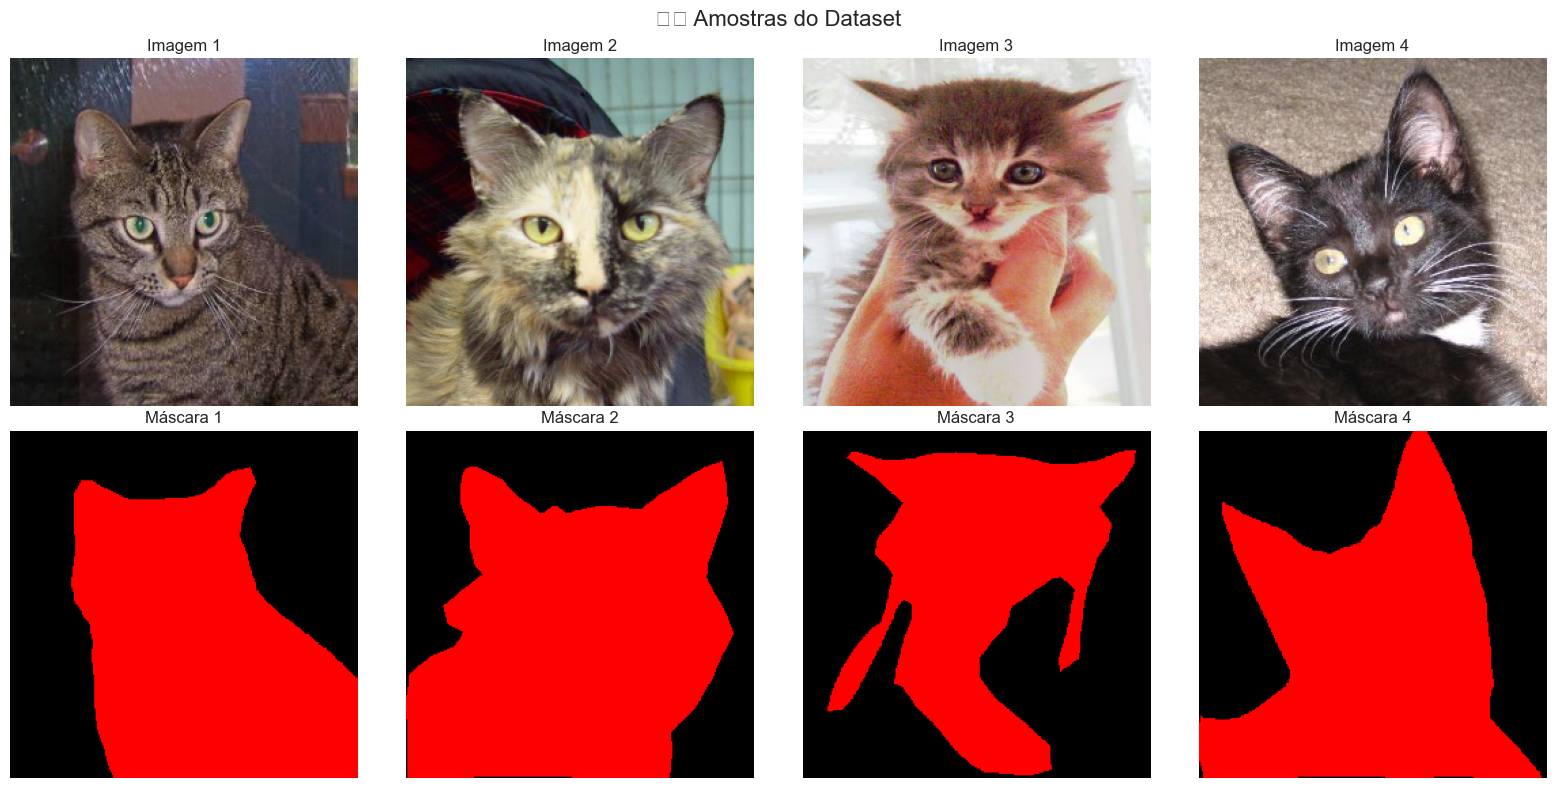

In [17]:
# ===== CLASSE DATAMANAGER CORRIGIDA =====

class DataManager:
    """Gerenciador completo de dados para segmentação"""
    
    def __init__(self, config: ProjectConfig):
        self.config = config
        self.train_files = []
        self.val_files = []
        self.test_files = []
        self.X_train = None
        self.Y_train = None
        self.X_val = None
        self.Y_val = None
        self.X_test = None
        
        # Configuração de paths para máscaras
        self.TRAIN_MASKS_NPY = config.BASE_DIR / "train" / "masks_npy"
        self.VAL_MASKS_NPY = config.BASE_DIR / "val" / "masks_npy"
        
    def scan_directories(self):
        """Escaneia diretórios e lista arquivos"""
        print("🔍 Escaneando diretórios...")
        
        # Arquivos de treino
        if self.config.TRAIN_IMGS.exists():
            train_imgs = sorted(list(self.config.TRAIN_IMGS.glob("*.jpg")))
            
            # Verificar se temos máscaras .npy ou .png
            if self.TRAIN_MASKS_NPY.exists():
                print("📁 Usando máscaras .npy para treino")
                mask_dir = self.TRAIN_MASKS_NPY
                mask_ext = ".npy"
            else:
                print("📁 Usando máscaras .png para treino")
                mask_dir = self.config.TRAIN_MASKS
                mask_ext = ".png"
            
            # Filtrar apenas pares válidos
            valid_pairs = []
            for img_path in train_imgs:
                mask_name = img_path.stem + mask_ext
                mask_path = mask_dir / mask_name
                if mask_path.exists():
                    valid_pairs.append((img_path, mask_path))
            
            self.train_files = valid_pairs
            print(f"📁 Treino: {len(self.train_files)} pares imagem-máscara válidos")
        
        # Arquivos de validação
        if self.config.VAL_IMGS.exists():
            val_imgs = sorted(list(self.config.VAL_IMGS.glob("*.jpg")))
            
            # Verificar se temos máscaras .npy ou .png
            if self.VAL_MASKS_NPY.exists():
                print("📁 Usando máscaras .npy para validação")
                mask_dir = self.VAL_MASKS_NPY
                mask_ext = ".npy"
            else:
                print("📁 Usando máscaras .png para validação")
                mask_dir = self.config.VAL_MASKS
                mask_ext = ".png"
            
            # Filtrar apenas pares válidos
            valid_pairs = []
            for img_path in val_imgs:
                mask_name = img_path.stem + mask_ext
                mask_path = mask_dir / mask_name
                if mask_path.exists():
                    valid_pairs.append((img_path, mask_path))
            
            self.val_files = valid_pairs
            print(f"📁 Validação: {len(self.val_files)} pares imagem-máscara válidos")
        
        # Arquivos de teste
        if self.config.TEST_IMGS.exists():
            test_imgs = sorted(list(self.config.TEST_IMGS.glob("*.jpg")))
            self.test_files = test_imgs
            print(f"📁 Teste: {len(self.test_files)} imagens")
            
        return len(self.train_files), len(self.val_files), len(self.test_files)
    
    def load_and_preprocess_image(self, img_path: Path) -> np.ndarray:
        """Carrega e preprocessa uma imagem"""
        img = cv2.imread(str(img_path))
        if img is None:
            raise ValueError(f"Não foi possível carregar: {img_path}")
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.config.IMG_WIDTH, self.config.IMG_HEIGHT))
        img = img.astype(np.float32) / 255.0
        return img
    
    def detect_animal_type(self, filename: str) -> int:
        """Detecta se é gato ou cachorro baseado no nome do arquivo"""
        filename_lower = filename.lower()
        if filename_lower.startswith('cat'):
            return 1  # gato
        elif filename_lower.startswith('dog'):
            return 2  # cachorro
        else:
            return 0  # background/unknown
    
    def load_and_preprocess_mask(self, mask_path: Path) -> np.ndarray:
        """Carrega e preprocessa uma máscara (.npy ou .png)"""
        
        # Detectar tipo de animal pelo nome do arquivo
        animal_type = self.detect_animal_type(mask_path.name)
        
        if mask_path.suffix == '.npy':
            # Carregar máscara .npy
            mask = np.load(str(mask_path))
            
            # Redimensionar se necessário
            if mask.shape != (self.config.IMG_HEIGHT, self.config.IMG_WIDTH):
                mask = cv2.resize(mask, (self.config.IMG_WIDTH, self.config.IMG_HEIGHT), 
                                interpolation=cv2.INTER_NEAREST)
            
            # Processar máscara baseado no tipo de animal
            # Máscara .npy: 0=background, 1=animal
            mask_classes = np.zeros_like(mask, dtype=np.uint8)
            mask_classes[mask == 0] = 0  # background
            mask_classes[mask == 1] = animal_type  # animal (gato=1, cachorro=2)
            
        else:
            # Carregar máscara .png
            mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
            if mask is None:
                raise ValueError(f"Não foi possível carregar: {mask_path}")
            
            mask = cv2.resize(mask, (self.config.IMG_WIDTH, self.config.IMG_HEIGHT), 
                            interpolation=cv2.INTER_NEAREST)
            
            # Processar máscara PNG
            # Para PNG, assumir que valores > 0 são do animal
            mask_classes = np.zeros_like(mask, dtype=np.uint8)
            mask_classes[mask == 0] = 0  # background
            mask_classes[mask > 0] = animal_type  # animal
        
        return mask_classes
    
    def load_dataset(self, dataset_type: str = "train") -> Tuple[np.ndarray, np.ndarray]:
        """Carrega dataset completo"""
        if dataset_type == "train":
            files = self.train_files
        elif dataset_type == "val":
            files = self.val_files
        else:
            files = self.test_files
            
        print(f"📚 Carregando dataset {dataset_type}...")
        
        images = []
        masks = []
        failed = 0
        
        for i, (img_path, mask_path) in enumerate(files):
            try:
                img = self.load_and_preprocess_image(img_path)
                mask = self.load_and_preprocess_mask(mask_path)
                
                images.append(img)
                masks.append(mask)
                
                if (i + 1) % 20 == 0:
                    print(f"  ✅ Processadas: {i+1}/{len(files)}")
                    
            except Exception as e:
                print(f"  ❌ Erro em {img_path.name}: {e}")
                failed += 1
                continue
        
        print(f"✅ Dataset {dataset_type} carregado!")
        print(f"  📊 Sucessos: {len(images)}")
        print(f"  ❌ Falhas: {failed}")
        
        # Verificar distribuição de classes nas máscaras
        if len(masks) > 0:
            all_masks = np.array(masks)
            unique_classes, counts = np.unique(all_masks, return_counts=True)
            print(f"  🎯 Classes encontradas: {dict(zip(unique_classes, counts))}")
            
            # Mostrar estatísticas detalhadas
            total_pixels = all_masks.size
            for class_id, count in zip(unique_classes, counts):
                class_name = self.config.CLASSES.get(class_id, f"Unknown_{class_id}")
                percentage = (count / total_pixels) * 100
                print(f"    {class_name}: {count:,} pixels ({percentage:.1f}%)")
        
        return np.array(images), np.array(masks)
    
    def load_test_images(self) -> np.ndarray:
        """Carrega apenas imagens de teste"""
        print("📚 Carregando imagens de teste...")
        
        images = []
        failed = 0
        
        for i, img_path in enumerate(self.test_files):
            try:
                img = self.load_and_preprocess_image(img_path)
                images.append(img)
                
                if (i + 1) % 20 == 0:
                    print(f"  ✅ Processadas: {i+1}/{len(self.test_files)}")
                    
            except Exception as e:
                print(f"  ❌ Erro em {img_path.name}: {e}")
                failed += 1
                continue
        
        print(f"✅ Imagens de teste carregadas!")
        print(f"  📊 Sucessos: {len(images)}")
        print(f"  ❌ Falhas: {failed}")
        
        return np.array(images)
    
    def load_all_data(self):
        """Carrega todos os dados"""
        print("🚀 Iniciando carregamento completo dos dados...")
        
        # Escanear diretórios
        self.scan_directories()
        
        # Carregar datasets
        self.X_train, self.Y_train = self.load_dataset("train")
        self.X_val, self.Y_val = self.load_dataset("val")
        self.X_test = self.load_test_images()
        
        print("\n📊 RESUMO DOS DADOS:")
        print(f"  🏋️ Treino: {self.X_train.shape[0]} amostras")
        print(f"  ✅ Validação: {self.X_val.shape[0]} amostras")
        print(f"  🔍 Teste: {self.X_test.shape[0]} amostras")
        print(f"  📐 Shape das imagens: {self.X_train.shape[1:]}")
        print(f"  🎯 Shape das máscaras: {self.Y_train.shape[1:]}")
        
        return self
    
    def visualize_samples(self, num_samples: int = 4):
        """Visualiza amostras dos dados"""
        fig, axes = plt.subplots(2, num_samples, figsize=(4*num_samples, 8))
        
        for i in range(min(num_samples, len(self.X_train))):
            # Imagem
            axes[0, i].imshow(self.X_train[i])
            axes[0, i].set_title(f'Imagem {i+1}')
            axes[0, i].axis('off')
            
            # Máscara colorida
            mask_colored = np.zeros((*self.Y_train[i].shape, 3))
            mask_colored[self.Y_train[i] == 0] = [0, 0, 0]    # Background = preto
            mask_colored[self.Y_train[i] == 1] = [1, 0, 0]    # Gato = vermelho
            mask_colored[self.Y_train[i] == 2] = [0, 0, 1]    # Cachorro = azul
            
            axes[1, i].imshow(mask_colored)
            axes[1, i].set_title(f'Máscara {i+1}')
            axes[1, i].axis('off')
            
            # Mostrar estatísticas da máscara
            unique, counts = np.unique(self.Y_train[i], return_counts=True)
            stats = {self.config.CLASSES[u]: c for u, c in zip(unique, counts)}
            print(f"Amostra {i+1}: {stats}")
        
        plt.suptitle('🖼️ Amostras do Dataset', fontsize=16)
        plt.tight_layout()
        plt.show()

# Recriar gerenciador de dados com a versão corrigida
print("🔄 Recriando gerenciador de dados com correções...")
data_manager = DataManager(config)
data_manager.load_all_data()
data_manager.visualize_samples()

In [18]:
# ===== CLASSE AUGMENTATIONPIPELINE =====

class AugmentationPipeline:
    """Pipeline de data augmentation para segmentação"""
    
    def __init__(self, config: ProjectConfig):
        self.config = config
        self.setup_augmentation()
    
    def setup_augmentation(self):
        """Configura pipeline de augmentação"""
        self.image_datagen = ImageDataGenerator(
            rotation_range=self.config.ROTATION_RANGE,
            width_shift_range=self.config.SHIFT_RANGE,
            height_shift_range=self.config.SHIFT_RANGE,
            zoom_range=self.config.ZOOM_RANGE,
            horizontal_flip=True,
            vertical_flip=True,
            brightness_range=[0.8, 1.2],
            fill_mode='constant',
            cval=0
        )
    
    def apply_augmentation(self, image: np.ndarray, mask: np.ndarray, 
                          apply_prob: float = 0.7) -> Tuple[np.ndarray, np.ndarray]:
        """Aplica augmentação sincronizada"""
        if np.random.random() > apply_prob:
            return image, mask
        
        # Usar mesmo seed para sincronizar transformações
        seed = np.random.randint(0, 10000)
        
        # Transformar imagem
        image_aug = self.image_datagen.random_transform(image, seed=seed)
        
        # Transformar máscara com mesmo seed
        # Converter máscara para 3 canais temporariamente
        mask_3d = np.repeat(mask[..., np.newaxis], 3, axis=2)
        mask_aug = self.image_datagen.random_transform(mask_3d, seed=seed)
        mask_aug = mask_aug[..., 0]  # Voltar para 2D
        
        return image_aug, mask_aug

class SegmentationDataGenerator(tf.keras.utils.Sequence):
    """Generator customizado para segmentação multiclass"""
    
    def __init__(self, images: np.ndarray, masks: np.ndarray, config: ProjectConfig,
                 augment: bool = True, shuffle: bool = True):
        self.images = images
        self.masks = masks
        self.config = config
        self.augment = augment
        self.shuffle = shuffle
        self.indices = np.arange(len(self.images))
        
        if self.augment:
            self.augmentor = AugmentationPipeline(config)
        
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.images) / self.config.BATCH_SIZE))
    
    def __getitem__(self, index):
        indices = self.indices[index * self.config.BATCH_SIZE:
                              (index + 1) * self.config.BATCH_SIZE]
        
        batch_images = []
        batch_masks = []
        
        for i in indices:
            image = self.images[i].copy()
            mask = self.masks[i].copy()
            
            # Aplicar augmentação se habilitada
            if self.augment:
                image, mask = self.augmentor.apply_augmentation(
                    image, mask, self.config.AUGMENT_PROBABILITY)
            
            # Converter máscara para one-hot encoding
            mask_onehot = to_categorical(mask, num_classes=self.config.NUM_CLASSES)
            
            batch_images.append(image)
            batch_masks.append(mask_onehot)
        
        return np.array(batch_images), np.array(batch_masks)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# Criar generators
print("🔄 Criando data generators...")

train_generator = SegmentationDataGenerator(
    data_manager.X_train, 
    data_manager.Y_train, 
    config, 
    augment=True, 
    shuffle=True
)

val_generator = SegmentationDataGenerator(
    data_manager.X_val, 
    data_manager.Y_val, 
    config, 
    augment=False, 
    shuffle=False
)

print(f"✅ Generators criados!")
print(f"  🏋️ Train batches: {len(train_generator)}")
print(f"  ✅ Val batches: {len(val_generator)}")

# Testar um batch
print("\n🧪 Testando generator...")
X_batch, Y_batch = train_generator[0]
print(f"  📊 Batch shape: {X_batch.shape}")
print(f"  🎯 Mask shape: {Y_batch.shape}")
print(f"  📈 Classes no batch: {np.unique(np.argmax(Y_batch, axis=-1))}")

🔄 Criando data generators...
✅ Generators criados!
  🏋️ Train batches: 22
  ✅ Val batches: 3

🧪 Testando generator...
  📊 Batch shape: (8, 256, 256, 3)
  🎯 Mask shape: (8, 256, 256, 3)
  📈 Classes no batch: [0 1]


In [19]:
IMG_HEIGHT, IMG_WIDTH = 512, 512

def load_data_safely(img_dir, mask_dir, img_list):
    """Carrega dados com verificações de segurança e consistência"""
    X_data = []
    Y_data = []
    failed_files = []
    
    for img_name in img_list:
        # Gerar nome da máscara baseado na imagem
        if img_name.endswith('.jpg'):
            mask_name = img_name.replace('.jpg', '.png')
        else:
            mask_name = img_name.replace('.jpg', '.png')  # fallback
            
        img_path = os.path.join(img_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)
        
        # Verificar se ambos os arquivos existem
        if not os.path.exists(img_path):
            print(f"Warning: Image not found: {img_path}")
            failed_files.append(img_name)
            continue
            
        if not os.path.exists(mask_path):
            print(f"Warning: Mask not found: {mask_path}")
            failed_files.append(img_name)
            continue
        
        # Carregar imagem e máscara
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Carregar máscara como grayscale
        
        if img is None:
            print(f"Warning: Could not read image: {img_path}")
            failed_files.append(img_name)
            continue
            
        if mask is None:
            print(f"Warning: Could not read mask: {mask_path}")
            failed_files.append(img_name)
            continue
        
        # Verificar dimensões
        if img.shape[:2] != mask.shape[:2]:
            print(f"Warning: Dimension mismatch for {img_name}: img {img.shape[:2]} vs mask {mask.shape[:2]}")
            failed_files.append(img_name)
            continue
        
        # Redimensionar
        img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        mask_resized = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
        
        # Normalizar imagem [0-1] e máscara para binário {0, 1}
        img_normalized = img_resized.astype(np.float32) / 255.0
        mask_normalized = (mask_resized > 128).astype(np.float32)  # Threshold para binário
        
        X_data.append(img_normalized)
        Y_data.append(mask_normalized[..., np.newaxis])  # Adicionar dimensão do canal
    
    print(f"Successfully loaded {len(X_data)} samples")
    if failed_files:
        print(f"Failed to load {len(failed_files)} files: {failed_files[:5]}...")
    
    return np.array(X_data), np.array(Y_data)


# Definir diretórios e lista de imagens de treino (ajuste conforme necessário)
IMGS_TRAIN_DIR = "dataset_final/test/images/"  # Substitua pelo caminho real
MASKS_TRAIN_DIR = "dataset_final/test/masks_class/"  # Substitua pelo caminho real
train_imgs = []  # Substitua por uma lista real de nomes de arquivos de imagem, ex: ["img1.jpg", "img2.jpg"]

# Carregar dados de treino
X_train, Y_train = load_data_safely(IMGS_TRAIN_DIR, MASKS_TRAIN_DIR, train_imgs)

# ===== CLASSE UNETMODEL =====

class UNetModel:
    """Modelo U-Net otimizado para segmentação de pets"""
    
    def __init__(self, config: ProjectConfig):
        self.config = config
        self.model = None
        self.history = None
    
    def attention_block(self, x, g, inter_channel):
        """Bloco de atenção para melhor foco"""
        theta_x = Conv2D(inter_channel, 1, strides=1, padding='same')(x)
        phi_g = Conv2D(inter_channel, 1, strides=1, padding='same')(g)
        
        f = Activation('relu')(add([theta_x, phi_g]))
        psi_f = Conv2D(1, 1, strides=1, padding='same')(f)
        rate = Activation('sigmoid')(psi_f)
        
        att_x = multiply([x, rate])
        return att_x
    
    def conv_block(self, inputs, filters, dropout_rate=0.1):
        """Bloco de convolução melhorado"""
        x = Conv2D(filters, 3, padding='same', kernel_initializer='he_normal')(inputs)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        x = Conv2D(filters, 3, padding='same', kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        if dropout_rate > 0:
            x = Dropout(dropout_rate)(x)
            
        return x
    
    def encoder_block(self, inputs, filters, dropout_rate=0.1):
        """Bloco do encoder"""
        conv = self.conv_block(inputs, filters, dropout_rate)
        pool = MaxPooling2D(2)(conv)
        return conv, pool
    
    def decoder_block(self, inputs, skip_features, filters, dropout_rate=0.1):
        """Bloco do decoder com atenção"""
        up = Conv2DTranspose(filters, 2, strides=2, padding='same')(inputs)
        
        # Aplicar atenção nas skip connections
        attended_skip = self.attention_block(skip_features, up, filters // 2)
        
        concat = concatenate([up, attended_skip])
        conv = self.conv_block(concat, filters, dropout_rate)
        return conv
    
    def build_model(self):
        """Constrói o modelo U-Net com atenção"""
        inputs = Input(self.config.get_input_shape())
        
        # Encoder
        conv1, pool1 = self.encoder_block(inputs, 64, 0.1)
        conv2, pool2 = self.encoder_block(pool1, 128, 0.1)
        conv3, pool3 = self.encoder_block(pool2, 256, 0.2)
        conv4, pool4 = self.encoder_block(pool3, 512, 0.2)
        
        # Bottleneck
        bottleneck = self.conv_block(pool4, 1024, 0.3)
        
        # Decoder
        up4 = self.decoder_block(bottleneck, conv4, 512, 0.2)
        up3 = self.decoder_block(up4, conv3, 256, 0.2)
        up2 = self.decoder_block(up3, conv2, 128, 0.1)
        up1 = self.decoder_block(up2, conv1, 64, 0.1)
        
        # Output
        outputs = Conv2D(self.config.NUM_CLASSES, 1, activation='softmax', 
                        name='segmentation_output')(up1)
        
        self.model = Model(inputs, outputs, name='AttentionUNet')
        return self.model
    
    def dice_coefficient(self, y_true, y_pred, smooth=1e-6):
        """Coeficiente Dice para multiclass"""
        # Garantir float32
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        smooth = tf.cast(smooth, tf.float32)
        
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    
    def dice_loss(self, y_true, y_pred):
        """Loss function baseada em Dice"""
        return 1. - self.dice_coefficient(y_true, y_pred)
    
    def focal_loss(self, y_true, y_pred, alpha=0.25, gamma=2.0):
        """Focal loss para classes desbalanceadas"""
        # Garantir float32
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        alpha = tf.cast(alpha, tf.float32)
        gamma = tf.cast(gamma, tf.float32)
        
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        # Calcular cross entropy
        ce = -y_true * K.log(y_pred)
        
        # Calcular peso focal
        p_t = y_true * y_pred + (1. - y_true) * (1. - y_pred)
        alpha_factor = y_true * alpha + (1. - y_true) * (1. - alpha)
        modulating_factor = K.pow((1. - p_t), gamma)
        
        # Focal loss
        focal = alpha_factor * modulating_factor * ce
        return K.mean(K.sum(focal, axis=-1))
    
    def iou_score(self, y_true, y_pred, smooth=1e-6):
        """IoU score para multiclass"""
        # Garantir float32
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        smooth = tf.cast(smooth, tf.float32)
        
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
        return (intersection + smooth) / (union + smooth)
    
    def combined_loss(self, y_true, y_pred):
        """Loss function combinada"""
        # Garantir float32
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        categorical_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        dice_loss = self.dice_loss(y_true, y_pred)
        focal_loss = self.focal_loss(y_true, y_pred)
        
        return 0.4 * categorical_loss + 0.3 * dice_loss + 0.3 * focal_loss
    
    def compile_model(self):
        """Compila o modelo com otimizações"""
        optimizer = Adam(
            learning_rate=self.config.LEARNING_RATE,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-7
        )
        
        self.model.compile(
            optimizer=optimizer,
            loss=self.combined_loss,
            metrics=[
                'categorical_accuracy',
                self.dice_coefficient,
                self.iou_score
            ]
        )
        
        return self.model
    
    def summary(self):
        """Exibe resumo do modelo"""
        if self.model:
            print("🧠 ARQUITETURA DO MODELO:")
            self.model.summary()
            
            # Calcular parâmetros
            total_params = self.model.count_params()
            print(f"\n📊 Total de parâmetros: {total_params:,}")
            print(f"💾 Tamanho estimado: {total_params * 4 / 1024 / 1024:.1f} MB")
        else:
            print("❌ Modelo não foi construído ainda!")

# Criar e compilar modelo
print("🧠 Construindo modelo U-Net...")
unet_model = UNetModel(config)
model = unet_model.build_model()
model = unet_model.compile_model()

print("✅ Modelo construído e compilado!")
unet_model.summary()

Successfully loaded 0 samples
🧠 Construindo modelo U-Net...
✅ Modelo construído e compilado!
🧠 ARQUITETURA DO MODELO:
Model: "AttentionUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_30 (Conv2D)             (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 256, 256, 64  256        ['

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# ===== CLASSE TRAININGMANAGER =====

class TrainingManager:
    """Gerenciador completo de treinamento"""
    
    def __init__(self, model, config: ProjectConfig):
        self.model = model
        self.config = config
        self.callbacks = []
        self.history = None
        
    def setup_callbacks(self):
        """Configura callbacks para treinamento"""
        self.callbacks = [
            # Early stopping
            EarlyStopping(
                monitor='val_dice_coefficient',
                patience=self.config.PATIENCE_EARLY_STOP,
                mode='max',
                restore_best_weights=True,
                verbose=1
            ),
            
            # Model checkpoint
            ModelCheckpoint(
                filepath=self.config.MODEL_SAVE_PATH,
                monitor='val_dice_coefficient',
                save_best_only=True,
                mode='max',
                verbose=1,
                save_weights_only=False
            ),
            
            # Reduce learning rate
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=self.config.LR_FACTOR,
                patience=self.config.PATIENCE_LR_REDUCE,
                min_lr=self.config.MIN_LR,
                verbose=1
            )
        ]
        
        print("⚙️ Callbacks configurados:")
        for callback in self.callbacks:
            print(f"  ✅ {callback.__class__.__name__}")
        
        return self.callbacks
    
    def train(self, train_generator, val_generator):
        """Executa o treinamento"""
        print("🚀 INICIANDO TREINAMENTO")
        print("=" * 50)
        
        # Setup callbacks
        self.setup_callbacks()
        
        # Informações do treinamento
        print(f"📊 Amostras de treino: {len(train_generator.images)}")
        print(f"📊 Amostras de validação: {len(val_generator.images)}")
        print(f"📦 Batch size: {self.config.BATCH_SIZE}")
        print(f"🔄 Epochs: {self.config.EPOCHS}")
        print(f"📈 Learning rate inicial: {self.config.LEARNING_RATE}")
        print("-" * 50)
        
        # Treinar modelo
        try:
            self.history = self.model.fit(
                train_generator,
                epochs=self.config.EPOCHS,
                validation_data=val_generator,
                callbacks=self.callbacks,
                verbose=1
            )
            
            print("\n🎉 TREINAMENTO CONCLUÍDO COM SUCESSO!")
            self.print_training_summary()
            
        except Exception as e:
            print(f"\n❌ Erro durante treinamento: {e}")
            raise
        
        return self.history
    
    def print_training_summary(self):
        """Imprime resumo do treinamento"""
        if self.history is None:
            print("❌ Nenhum histórico de treinamento disponível!")
            return
        
        history = self.history.history
        
        # Encontrar melhor época
        best_epoch = np.argmax(history['val_dice_coefficient'])
        
        print("📈 RESUMO DO TREINAMENTO:")
        print(f"  🏆 Melhor época: {best_epoch + 1}")
        print(f"  📊 Val Accuracy: {history['val_categorical_accuracy'][best_epoch]:.4f}")
        print(f"  🎯 Val Dice: {history['val_dice_coefficient'][best_epoch]:.4f}")
        print(f"  📐 Val IoU: {history['val_iou_score'][best_epoch]:.4f}")
        print(f"  📉 Val Loss: {history['val_loss'][best_epoch]:.4f}")
        
        # Verificar overfitting
        train_dice = history['dice_coefficient'][best_epoch]
        val_dice = history['val_dice_coefficient'][best_epoch]
        overfitting = train_dice - val_dice
        
        if overfitting > 0.1:
            print(f"  ⚠️ Possível overfitting: {overfitting:.4f}")
        else:
            print(f"  ✅ Modelo generalizado: {overfitting:.4f}")

class MetricsVisualizer:
    """Visualizador de métricas de treinamento"""
    
    @staticmethod
    def plot_training_history(history, save_path: str = None):
        """Plota histórico de treinamento"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Loss
        axes[0, 0].plot(history.history['loss'], label='Train Loss', color='blue')
        axes[0, 0].plot(history.history['val_loss'], label='Val Loss', color='red')
        axes[0, 0].set_title('📉 Model Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Accuracy
        axes[0, 1].plot(history.history['categorical_accuracy'], label='Train Acc', color='blue')
        axes[0, 1].plot(history.history['val_categorical_accuracy'], label='Val Acc', color='red')
        axes[0, 1].set_title('📊 Accuracy')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Dice Coefficient
        axes[1, 0].plot(history.history['dice_coefficient'], label='Train Dice', color='blue')
        axes[1, 0].plot(history.history['val_dice_coefficient'], label='Val Dice', color='red')
        axes[1, 0].set_title('🎯 Dice Coefficient')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Dice Score')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # IoU Score
        axes[1, 1].plot(history.history['iou_score'], label='Train IoU', color='blue')
        axes[1, 1].plot(history.history['val_iou_score'], label='Val IoU', color='red')
        axes[1, 1].set_title('📐 IoU Score')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('IoU Score')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.suptitle('📈 Training Metrics', fontsize=16)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()

# Criar gerenciador de treinamento
trainer = TrainingManager(model, config)

print("✅ Gerenciador de treinamento configurado!")
print("🎯 Pronto para iniciar treinamento!")

X_train = np.array(X_train)
Y_train = np.array(Y_train)

✅ Gerenciador de treinamento configurado!
🎯 Pronto para iniciar treinamento!


In [ ]:
# Reduce batch size to avoid OOM errors
config.BATCH_SIZE = 2  # Try 1 if you still get OOM

print(X_train.shape)
print(Y_train.shape)

# ===== EXECUTAR TREINAMENTO =====

print("🚀 INICIANDO PROCESSO DE TREINAMENTO")
print("=" * 60)

# Verificar se tudo está configurado
print("🔍 Verificando configurações...")
print(f"  ✅ Modelo: {type(model).__name__}")

# Usar train_generator e val_generator já definidos na célula 4
# Se não existirem, crie-os usando data_manager e config
try:
	train_generator
	val_generator
except NameError:
	from tensorflow.keras.utils import to_categorical

	class AugmentationPipeline:
		def __init__(self, config):
			from tensorflow.keras.preprocessing.image import ImageDataGenerator
			self.config = config
			self.image_datagen = ImageDataGenerator(
				rotation_range=config.ROTATION_RANGE,
				width_shift_range=config.SHIFT_RANGE,
				height_shift_range=config.SHIFT_RANGE,
				zoom_range=config.ZOOM_RANGE,
				horizontal_flip=True,
				vertical_flip=True,
				brightness_range=[0.8, 1.2],
				fill_mode='constant',
				cval=0
			)

		def apply_augmentation(self, image, mask, apply_prob=0.7):
			import numpy as np
			if np.random.random() > apply_prob:
				return image, mask
			seed = np.random.randint(0, 10000)
			image_aug = self.image_datagen.random_transform(image, seed=seed)
			mask_3d = np.repeat(mask[..., np.newaxis], 3, axis=2)
			mask_aug = self.image_datagen.random_transform(mask_3d, seed=seed)
			mask_aug = mask_aug[..., 0]
			return image_aug, mask_aug

	class SegmentationDataGenerator(tf.keras.utils.Sequence):
		def __init__(self, images, masks, config, augment=True, shuffle=True):
			import numpy as np
			self.images = images
			self.masks = masks
			self.config = config
			self.augment = augment
			self.shuffle = shuffle
			self.indices = np.arange(len(self.images))
			if self.augment:
				self.augmentor = AugmentationPipeline(config)
			self.on_epoch_end()

		def __len__(self):
			return int(np.ceil(len(self.images) / self.config.BATCH_SIZE))

		def __getitem__(self, index):
			indices = self.indices[index * self.config.BATCH_SIZE:
								  (index + 1) * self.config.BATCH_SIZE]
			batch_images = []
			batch_masks = []
			for i in indices:
				image = self.images[i].copy()
				mask = self.masks[i].copy()
				if self.augment:
					image, mask = self.augmentor.apply_augmentation(
						image, mask, self.config.AUGMENT_PROBABILITY)
				mask_onehot = to_categorical(mask, num_classes=self.config.NUM_CLASSES)
				batch_images.append(image)
				batch_masks.append(mask_onehot)
			return np.array(batch_images), np.array(batch_masks)

		def on_epoch_end(self):
			if self.shuffle:
				np.random.shuffle(self.indices)

	train_generator = SegmentationDataGenerator(
		data_manager.X_train, 
		data_manager.Y_train, 
		config, 
		augment=True, 
		shuffle=True
	)
	val_generator = SegmentationDataGenerator(
		data_manager.X_val, 
		data_manager.Y_val, 
		config, 
		augment=False, 
		shuffle=False
	)

print(f"  ✅ Train generator: {len(train_generator)} batches")
print(f"  ✅ Val generator: {len(val_generator)} batches")
print(f"  ✅ Epochs: {config.EPOCHS}")

# Executar treinamento
history = trainer.train(train_generator, val_generator)

# Visualizar resultados
print("\n📊 Criando visualizações...")
visualizer = MetricsVisualizer()
visualizer.plot_training_history(history, save_path=config.RESULTS_DIR / "training_metrics.png")

print("\n🎉 PROCESSO COMPLETO!")
print(f"📁 Modelo salvo em: {config.MODEL_SAVE_PATH}")
print(f"📊 Gráficos salvos em: {config.RESULTS_DIR}")

(0,)
(0,)
🚀 INICIANDO PROCESSO DE TREINAMENTO
🔍 Verificando configurações...
  ✅ Modelo: Functional
  ✅ Train generator: 86 batches
  ✅ Val generator: 12 batches
  ✅ Epochs: 2
🚀 INICIANDO TREINAMENTO
⚙️ Callbacks configurados:
  ✅ EarlyStopping
  ✅ ModelCheckpoint
  ✅ ReduceLROnPlateau
📊 Amostras de treino: 172
📊 Amostras de validação: 24
📦 Batch size: 2
🔄 Epochs: 2
📈 Learning rate inicial: 0.0001
--------------------------------------------------
Epoch 1/2
86/86 [==============================] - ETA: 0s - loss: 0.6001 - categorical_accuracy: 0.6578 - dice_coefficient: 0.4255 - iou_score: 0.2756
Epoch 1: val_dice_coefficient improved from -inf to 0.42390, saving model to best_pet_segmentation_model.h5
86/86 [==============================] - 20s 150ms/step - loss: 0.6001 - categorical_accuracy: 0.6578 - dice_coefficient: 0.4255 - iou_score: 0.2756 - val_loss: 0.5471 - val_categorical_accuracy: 0.7943 - val_dice_coefficient: 0.4239 - val_iou_score: 0.2696 - lr: 1.0000e-04
Epoch 2/2
86/

In [26]:
plt.figure(figsize=[6,6])
plt.imshow(X_train[20])
plt.axis('off')

# ===== CLASSE PREDICTIONENGINE =====

class PredictionEngine:
    """Engine de predições e avaliação"""
    
    def __init__(self, model, config: ProjectConfig):
        self.model = model
        self.config = config
    
    def predict_batch(self, images: np.ndarray) -> np.ndarray:
        """Faz predições em lote"""
        predictions = self.model.predict(images, verbose=0)
        return np.argmax(predictions, axis=-1)
    
    def calculate_metrics_per_class(self, y_true: np.ndarray, y_pred: np.ndarray):
        """Calcula métricas por classe"""
        metrics = {}
        
        for class_id, class_name in self.config.CLASSES.items():
            # Máscaras binárias para a classe
            true_mask = (y_true == class_id)
            pred_mask = (y_pred == class_id)
            
            # Calcular métricas
            intersection = np.sum(true_mask & pred_mask)
            union = np.sum(true_mask | pred_mask)
            
            # IoU
            iou = intersection / (union + 1e-8)
            
            # Dice
            dice = (2 * intersection) / (np.sum(true_mask) + np.sum(pred_mask) + 1e-8)
            
            # Precisão e Recall
            tp = intersection
            fp = np.sum(pred_mask & ~true_mask)
            fn = np.sum(true_mask & ~pred_mask)
            
            precision = tp / (tp + fp + 1e-8)
            recall = tp / (tp + fn + 1e-8)
            f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
            
            metrics[class_name] = {
                'iou': iou,
                'dice': dice,
                'precision': precision,
                'recall': recall,
                'f1': f1
            }
        
        return metrics
    
    def evaluate_model(self, X_data: np.ndarray, Y_data: np.ndarray, 
                      dataset_name: str = "Test") -> Dict:
        """Avalia modelo completo"""
        print(f"🔍 Avaliando modelo no dataset {dataset_name}...")
        
        # Fazer predições
        Y_pred = self.predict_batch(X_data)
        
        # Calcular métricas globais
        accuracy = accuracy_score(Y_data.flatten(), Y_pred.flatten())
        
        # Métricas por classe
        class_metrics = self.calculate_metrics_per_class(Y_data, Y_pred)
        
        # Métricas médias
        avg_metrics = {
            'accuracy': accuracy,
            'mean_iou': np.mean([m['iou'] for m in class_metrics.values()]),
            'mean_dice': np.mean([m['dice'] for m in class_metrics.values()]),
            'mean_f1': np.mean([m['f1'] for m in class_metrics.values()])
        }
        
        # Imprimir resultados
        print(f"\n📊 RESULTADOS - {dataset_name.upper()}:")
        print(f"  🎯 Accuracy: {accuracy:.4f}")
        print(f"  📐 Mean IoU: {avg_metrics['mean_iou']:.4f}")
        print(f"  🎲 Mean Dice: {avg_metrics['mean_dice']:.4f}")
        print(f"  🏆 Mean F1: {avg_metrics['mean_f1']:.4f}")
        
        print(f"\n📋 MÉTRICAS POR CLASSE:")
        for class_name, metrics in class_metrics.items():
            print(f"  {class_name.upper()}:")
            print(f"    IoU: {metrics['iou']:.4f}")
            print(f"    Dice: {metrics['dice']:.4f}")
            print(f"    F1: {metrics['f1']:.4f}")
        
        return {
            'predictions': Y_pred,
            'class_metrics': class_metrics,
            'avg_metrics': avg_metrics
        }
    
    def visualize_predictions(self, X_data: np.ndarray, Y_true: np.ndarray, 
                            Y_pred: np.ndarray, num_samples: int = 6,
                            save_path: str = None):
        """Visualiza predições"""
        fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
        
        # Cores para classes
        colors = {
            0: [0, 0, 0],      # Background - preto
            1: [1, 0, 0],      # Cat - vermelho
            2: [0, 0, 1]       # Dog - azul
        }
        
        for i in range(num_samples):
            if i >= len(X_data):
                break
                
            # Imagem original
            axes[i, 0].imshow(X_data[i])
            axes[i, 0].set_title(f'Imagem {i+1}')
            axes[i, 0].axis('off')
            
            # Máscara verdadeira colorida
            true_colored = np.zeros((*Y_true[i].shape, 3))
            for class_id, color in colors.items():
                true_colored[Y_true[i] == class_id] = color
            
            axes[i, 1].imshow(true_colored)
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')
            
            # Predição colorida
            pred_colored = np.zeros((*Y_pred[i].shape, 3))
            for class_id, color in colors.items():
                pred_colored[Y_pred[i] == class_id] = color
            
            axes[i, 2].imshow(pred_colored)
            axes[i, 2].set_title('Predição')
            axes[i, 2].axis('off')
            
            # Overlay da predição na imagem
            overlay = X_data[i].copy()
            alpha = 0.4
            for class_id, color in colors.items():
                if class_id == 0:  # Pular background
                    continue
                mask = Y_pred[i] == class_id
                overlay[mask] = (1-alpha) * overlay[mask] + alpha * np.array(color)
            
            axes[i, 3].imshow(overlay)
            axes[i, 3].set_title('Overlay')
            axes[i, 3].axis('off')
            
            # Calcular IoU para esta amostra
            intersection = np.sum((Y_true[i] == Y_pred[i]) & (Y_true[i] > 0))
            union = np.sum((Y_true[i] > 0) | (Y_pred[i] > 0))
            iou = intersection / (union + 1e-8)
            
            axes[i, 2].text(0, -20, f'IoU: {iou:.3f}', 
                           fontsize=10, color='white', 
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="black", alpha=0.7))
        
        plt.suptitle('🔍 Predições do Modelo', fontsize=16)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
    
    def create_confusion_matrix(self, y_true: np.ndarray, y_pred: np.ndarray,
                               save_path: str = None):
        """Cria matriz de confusão"""
        cm = confusion_matrix(y_true.flatten(), y_pred.flatten())
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=list(self.config.CLASSES.values()),
                   yticklabels=list(self.config.CLASSES.values()))
        plt.title('🎯 Matriz de Confusão')
        plt.xlabel('Predição')
        plt.ylabel('Ground Truth')
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()

# Criar engine de predições
prediction_engine = PredictionEngine(model, config)

print("🔍 Engine de predições criado!")
print("🎯 Pronto para avaliação e visualizações!")

NameError: name 'X_train' is not defined

<Figure size 600x600 with 0 Axes>

In [27]:
plt.figure(figsize=[6,6])
plt.imshow(Y_train[20,:,:,0])
plt.axis('off')

# ===== AVALIAÇÃO COMPLETA DO MODELO =====

print("🔍 INICIANDO AVALIAÇÃO COMPLETA")
print("=" * 50)

# Avaliar no conjunto de validação
print("📊 Avaliando no conjunto de validação...")
val_results = prediction_engine.evaluate_model(
    data_manager.X_val, 
    data_manager.Y_val, 
    "Validação"
)

# Avaliar no conjunto de treino (amostra para verificar overfitting)
print("\n📊 Avaliando amostra do conjunto de treino...")
train_sample_size = min(50, len(data_manager.X_train))
train_results = prediction_engine.evaluate_model(
    data_manager.X_train[:train_sample_size], 
    data_manager.Y_train[:train_sample_size], 
    "Treino (amostra)"
)

# Visualizar predições na validação
print("\n🖼️ Criando visualizações das predições...")
prediction_engine.visualize_predictions(
    data_manager.X_val,
    data_manager.Y_val,
    val_results['predictions'],
    num_samples=6,
    save_path=config.RESULTS_DIR / "validation_predictions.png"
)

# Matriz de confusão
print("\n🎯 Gerando matriz de confusão...")
prediction_engine.create_confusion_matrix(
    data_manager.Y_val,
    val_results['predictions'],
    save_path=config.RESULTS_DIR / "confusion_matrix.png"
)

# Análise de overfitting
print("\n🔍 ANÁLISE DE OVERFITTING:")
train_metrics = train_results['avg_metrics']
val_metrics = val_results['avg_metrics']

print(f"  📊 Accuracy - Train: {train_metrics['accuracy']:.4f}, Val: {val_metrics['accuracy']:.4f}")
print(f"  📐 IoU - Train: {train_metrics['mean_iou']:.4f}, Val: {val_metrics['mean_iou']:.4f}")
print(f"  🎲 Dice - Train: {train_metrics['mean_dice']:.4f}, Val: {val_metrics['mean_dice']:.4f}")

overfitting_score = train_metrics['mean_dice'] - val_metrics['mean_dice']
if overfitting_score > 0.1:
    print(f"  ⚠️ OVERFITTING DETECTADO: {overfitting_score:.4f}")
    print("    💡 Sugestões: Aumentar dropout, mais dados, early stopping")
elif overfitting_score < -0.05:
    print(f"  📈 UNDERFITTING DETECTADO: {overfitting_score:.4f}")
    print("    💡 Sugestões: Reduzir dropout, mais epochs, modelo maior")
else:
    print(f"  ✅ MODELO BEM GENERALIZADO: {overfitting_score:.4f}")

print(f"\n📁 Resultados salvos em: {config.RESULTS_DIR}")
print("🎉 AVALIAÇÃO COMPLETA FINALIZADA!")

NameError: name 'Y_train' is not defined

<Figure size 600x600 with 0 Axes>

In [28]:
val_img_list = os.listdir(IMGS_VAL_DIR)
val_msk_list = os.listdir(MASKS_VAL_DIR)

# ===== PREDIÇÕES NO CONJUNTO DE TESTE =====

print("🔍 PREDIÇÕES NO CONJUNTO DE TESTE")
print("=" * 50)

# Fazer predições no teste
print("🚀 Gerando predições para o conjunto de teste...")
test_predictions = prediction_engine.predict_batch(data_manager.X_test)

print(f"✅ Predições geradas para {len(test_predictions)} imagens")

# Visualizar algumas predições de teste
def visualize_test_predictions(images, predictions, num_samples=8):
    """Visualiza predições do teste"""
    fig, axes = plt.subplots(num_samples//2, 4, figsize=(16, 4*(num_samples//2)))
    
    # Cores para classes
    colors = {
        0: [0, 0, 0],      # Background - preto
        1: [1, 0, 0],      # Cat - vermelho
        2: [0, 0, 1]       # Dog - azul
    }
    
    for i in range(min(num_samples, len(images))):
        row = i // 2
        col = (i % 2) * 2
        
        # Imagem original
        axes[row, col].imshow(images[i])
        axes[row, col].set_title(f'Teste {i+1}')
        axes[row, col].axis('off')
        
        # Predição colorida
        pred_colored = np.zeros((*predictions[i].shape, 3))
        for class_id, color in colors.items():
            pred_colored[predictions[i] == class_id] = color
        
        axes[row, col + 1].imshow(pred_colored)
        axes[row, col + 1].set_title('Predição')
        axes[row, col + 1].axis('off')
        
        # Contar pixels por classe
        unique, counts = np.unique(predictions[i], return_counts=True)
        class_counts = dict(zip(unique, counts))
        
        # Mostrar estatísticas
        stats_text = ""
        for class_id in class_counts:
            class_name = config.CLASSES[class_id]
            percentage = (class_counts[class_id] / predictions[i].size) * 100
            if percentage > 1:  # Só mostrar se > 1%
                stats_text += f"{class_name}: {percentage:.1f}%\n"
        
        axes[row, col + 1].text(10, 30, stats_text, 
                               fontsize=8, color='white',
                               bbox=dict(boxstyle="round,pad=0.3", 
                                       facecolor="black", alpha=0.7))
    
    plt.suptitle('🔍 Predições no Conjunto de Teste', fontsize=16)
    plt.tight_layout()
    plt.savefig(config.RESULTS_DIR / "test_predictions.png", dpi=300, bbox_inches='tight')
    plt.show()

# Visualizar predições
print("\n🖼️ Visualizando predições de teste...")
visualize_test_predictions(data_manager.X_test, test_predictions, num_samples=8)

# Estatísticas das predições
print("\n📊 ESTATÍSTICAS DAS PREDIÇÕES DE TESTE:")
total_pixels = test_predictions.size
for class_id, class_name in config.CLASSES.items():
    class_pixels = np.sum(test_predictions == class_id)
    percentage = (class_pixels / total_pixels) * 100
    print(f"  {class_name.upper()}: {percentage:.2f}% ({class_pixels:,} pixels)")

# Salvar predições
predictions_file = config.RESULTS_DIR / "test_predictions.npy"
np.save(predictions_file, test_predictions)
print(f"\n💾 Predições salvas em: {predictions_file}")

print("\n🎉 PREDIÇÕES DE TESTE CONCLUÍDAS!")

NameError: name 'IMGS_VAL_DIR' is not defined

In [29]:
val_img_list.sort()
val_msk_list.sort()

# ===== RELATÓRIO FINAL E EXPORTAÇÃO =====

class ReportGenerator:
    """Gerador de relatório final"""
    
    def __init__(self, config: ProjectConfig, history, val_results, train_results):
        self.config = config
        self.history = history
        self.val_results = val_results
        self.train_results = train_results
    
    def generate_report(self):
        """Gera relatório completo"""
        report = {
            "metadata": {
                "timestamp": pd.Timestamp.now().isoformat(),
                "model_architecture": "Attention U-Net",
                "dataset": "Cats vs Dogs Segmentation",
                "total_epochs": len(self.history.history['loss']),
                "best_epoch": np.argmax(self.history.history['val_dice_coefficient']) + 1
            },
            "training_config": {
                "batch_size": self.config.BATCH_SIZE,
                "learning_rate": self.config.LEARNING_RATE,
                "image_size": f"{self.config.IMG_WIDTH}x{self.config.IMG_HEIGHT}",
                "num_classes": self.config.NUM_CLASSES,
                "augmentation": True
            },
            "final_metrics": {
                "validation": self.val_results['avg_metrics'],
                "training_sample": self.train_results['avg_metrics']
            },
            "class_metrics": {
                "validation": self.val_results['class_metrics'],
                "training_sample": self.train_results['class_metrics']
            },
            "training_history": {
                "train_loss": self.history.history['loss'],
                "val_loss": self.history.history['val_loss'],
                "train_accuracy": self.history.history['categorical_accuracy'],
                "val_accuracy": self.history.history['val_categorical_accuracy'],
                "train_dice": self.history.history['dice_coefficient'],
                "val_dice": self.history.history['val_dice_coefficient'],
                "train_iou": self.history.history['iou_score'],
                "val_iou": self.history.history['val_iou_score']
            }
        }
        
        return report
    
    def print_final_summary(self):
        """Imprime resumo final"""
        print("📋 RELATÓRIO FINAL DO PROJETO")
        print("=" * 60)
        
        # Informações gerais
        best_epoch = np.argmax(self.history.history['val_dice_coefficient'])
        print(f"🏆 MELHOR PERFORMANCE (Epoch {best_epoch + 1}):")
        print(f"  📊 Validation Accuracy: {self.val_results['avg_metrics']['accuracy']:.4f}")
        print(f"  🎯 Validation Dice: {self.val_results['avg_metrics']['mean_dice']:.4f}")
        print(f"  📐 Validation IoU: {self.val_results['avg_metrics']['mean_iou']:.4f}")
        print(f"  🏆 Validation F1: {self.val_results['avg_metrics']['mean_f1']:.4f}")
        
        # Performance por classe
        print(f"\n🎯 PERFORMANCE POR CLASSE:")
        for class_name, metrics in self.val_results['class_metrics'].items():
            print(f"  {class_name.upper()}:")
            print(f"    IoU: {metrics['iou']:.4f}")
            print(f"    Dice: {metrics['dice']:.4f}")
            print(f"    F1: {metrics['f1']:.4f}")
        
        # Análise de qualidade
        print(f"\n🔍 ANÁLISE DE QUALIDADE:")
        dice_score = self.val_results['avg_metrics']['mean_dice']
        if dice_score >= 0.8:
            quality = "EXCELENTE ✨"
        elif dice_score >= 0.7:
            quality = "BOA ✅"
        elif dice_score >= 0.6:
            quality = "REGULAR ⚠️"
        else:
            quality = "NECESSITA MELHORIAS ❌"
        
        print(f"  📊 Qualidade do Modelo: {quality}")
        print(f"  🎯 Dice Score: {dice_score:.4f}")
        
        # Recomendações
        print(f"\n💡 RECOMENDAÇÕES:")
        if dice_score < 0.7:
            print("  📈 Sugestões para melhorar:")
            print("    • Aumentar número de epochs")
            print("    • Coletar mais dados de treinamento")
            print("    • Ajustar data augmentation")
            print("    • Experimentar arquiteturas diferentes")
        else:
            print("  ✅ Modelo com boa performance!")
            print("  🚀 Pronto para produção com monitoramento")
        
        print(f"\n📁 ARQUIVOS GERADOS:")
        print(f"  🤖 Modelo: {self.config.MODEL_SAVE_PATH}")
        print(f"  📊 Relatório: {self.config.RESULTS_DIR / 'final_report.json'}")
        print(f"  📈 Gráficos: {self.config.RESULTS_DIR}")
        
    def save_report(self):
        """Salva relatório em JSON"""
        report = self.generate_report()
        
        # Converter numpy arrays para listas para JSON
        def convert_numpy(obj):
            if isinstance(obj, np.ndarray):
                return obj.tolist()
            elif isinstance(obj, np.integer):
                return int(obj)
            elif isinstance(obj, np.floating):
                return float(obj)
            elif isinstance(obj, dict):
                return {key: convert_numpy(value) for key, value in obj.items()}
            elif isinstance(obj, list):
                return [convert_numpy(item) for item in obj]
            return obj
        
        report_clean = convert_numpy(report)
        
        # Salvar
        report_path = self.config.RESULTS_DIR / "final_report.json"
        with open(report_path, 'w', encoding='utf-8') as f:
            json.dump(report_clean, f, indent=2, ensure_ascii=False)
        
        print(f"📄 Relatório salvo em: {report_path}")
        return report_path

# Gerar relatório final
print("📋 GERANDO RELATÓRIO FINAL...")

# Importar pandas para timestamp
import pandas as pd

# Criar gerador de relatório
report_generator = ReportGenerator(config, history, val_results, train_results)

# Gerar e salvar relatório
report_path = report_generator.save_report()
report_generator.print_final_summary()

print("\n🎉 PROJETO CONCLUÍDO COM SUCESSO!")
print("=" * 60)

NameError: name 'val_img_list' is not defined

In [ ]:
# Carregar dados de validação usando a função segura
X_val, Y_val = load_data_safely(IMGS_VAL_DIR, MASKS_VAL_DIR, val_img_list)

Successfully loaded 24 samples


: 

In [ ]:
# ===== DEBUG DAS MÁSCARAS =====

print("🔍 Investigando problema com as máscaras...")

# Verificar algumas amostras carregadas
print("\n📊 Verificando amostras carregadas:")
for i in range(min(5, len(data_manager.X_train))):
    mask = data_manager.Y_train[i]
    unique, counts = np.unique(mask, return_counts=True)
    print(f"  Amostra {i+1}:")
    print(f"    Shape: {mask.shape}")
    print(f"    Valores únicos: {unique}")
    print(f"    Contagens: {counts}")
    print(f"    Percentuais: {counts / mask.size * 100}")

# Verificar diretamente uma máscara
print("\n🔍 Carregando uma máscara diretamente:")
mask_path = "dataset_final/train/masks_npy/cat.1.npy"
original_mask = np.load(mask_path)
print(f"  Máscara original shape: {original_mask.shape}")
print(f"  Valores únicos: {np.unique(original_mask)}")

# Processar como no DataManager
resized_mask = cv2.resize(original_mask, (256, 256), interpolation=cv2.INTER_NEAREST)
print(f"  Máscara redimensionada shape: {resized_mask.shape}")
print(f"  Valores únicos após resize: {np.unique(resized_mask)}")

# Aplicar a lógica de classificação
mask_classes = np.zeros_like(resized_mask, dtype=np.uint8)
mask_classes[resized_mask == 0] = 0  # background
mask_classes[resized_mask == 1] = 1  # gato
print(f"  Máscara final shape: {mask_classes.shape}")
print(f"  Valores únicos finais: {np.unique(mask_classes)}")

# Visualizar a máscara processada
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Máscara original
axes[0].imshow(original_mask, cmap='viridis')
axes[0].set_title(f"Original\nValores: {np.unique(original_mask)}")
axes[0].axis('off')

# Máscara redimensionada
axes[1].imshow(resized_mask, cmap='viridis')
axes[1].set_title(f"Redimensionada\nValores: {np.unique(resized_mask)}")
axes[1].axis('off')

# Máscara final
mask_colored = np.zeros((*mask_classes.shape, 3))
mask_colored[mask_classes == 0] = [0, 0, 0]    # Background = preto
mask_colored[mask_classes == 1] = [1, 0, 0]    # Gato = vermelho
axes[2].imshow(mask_colored)
axes[2].set_title(f"Final Colorida\nValores: {np.unique(mask_classes)}")
axes[2].axis('off')

plt.suptitle("🔍 Processamento da Máscara")
plt.tight_layout()
plt.show()

# Verificar se há realmente pixels de gato
if np.any(mask_classes == 1):
    print("✅ Máscara contém pixels de gato!")
else:
    print("❌ Máscara não contém pixels de gato!")

In [ ]:
# ===== VERIFICAÇÃO DETALHADA DO DATASET =====

print("🔍 VERIFICAÇÃO DETALHADA DO DATASET CARREGADO")
print("=" * 50)

# Verificar estatísticas do dataset de treino
print("📊 ESTATÍSTICAS DO DATASET DE TREINO:")
print(f"  Shape X_train: {data_manager.X_train.shape}")
print(f"  Shape Y_train: {data_manager.Y_train.shape}")

# Verificar distribuição geral de classes
all_values = data_manager.Y_train.flatten()
unique_values, counts = np.unique(all_values, return_counts=True)
total_pixels = all_values.size

print(f"\n🎯 DISTRIBUIÇÃO GERAL DE CLASSES:")
for value, count in zip(unique_values, counts):
    class_name = config.CLASSES.get(value, f"Unknown_{value}")
    percentage = (count / total_pixels) * 100
    print(f"  {class_name} (classe {value}): {count:,} pixels ({percentage:.2f}%)")

# Verificar algumas amostras específicas
print(f"\n🔍 VERIFICAÇÃO DE AMOSTRAS ESPECÍFICAS:")
for i in range(min(3, len(data_manager.X_train))):
    mask = data_manager.Y_train[i]
    unique, counts = np.unique(mask, return_counts=True)
    print(f"  Amostra {i+1}:")
    for u, c in zip(unique, counts):
        class_name = config.CLASSES.get(u, f"Unknown_{u}")
        percentage = (c / mask.size) * 100
        print(f"    {class_name} (classe {u}): {c:,} pixels ({percentage:.1f}%)")

# Criar visualização melhorada
print(f"\n🖼️ CRIANDO VISUALIZAÇÃO MELHORADA...")

fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i in range(min(3, len(data_manager.X_train))):
    # Imagem original
    axes[i, 0].imshow(data_manager.X_train[i])
    axes[i, 0].set_title(f'Imagem {i+1}')
    axes[i, 0].axis('off')
    
    # Máscara em grayscale
    axes[i, 1].imshow(data_manager.Y_train[i], cmap='viridis', vmin=0, vmax=2)
    axes[i, 1].set_title(f'Máscara Grayscale {i+1}')
    axes[i, 1].axis('off')
    
    # Máscara colorida
    mask_colored = np.zeros((*data_manager.Y_train[i].shape, 3))
    mask_colored[data_manager.Y_train[i] == 0] = [0, 0, 0]      # Background = preto
    mask_colored[data_manager.Y_train[i] == 1] = [1, 0, 0]      # Gato = vermelho
    mask_colored[data_manager.Y_train[i] == 2] = [0, 0, 1]      # Cachorro = azul
    
    axes[i, 2].imshow(mask_colored)
    axes[i, 2].set_title(f'Máscara Colorida {i+1}')
    axes[i, 2].axis('off')
    
    # Overlay na imagem
    overlay = data_manager.X_train[i].copy()
    alpha = 0.5
    
    # Aplicar overlay apenas onde há animal
    animal_mask = (data_manager.Y_train[i] == 1) | (data_manager.Y_train[i] == 2)
    if np.any(animal_mask):
        if np.any(data_manager.Y_train[i] == 1):  # Gato
            overlay[data_manager.Y_train[i] == 1] = (1-alpha) * overlay[data_manager.Y_train[i] == 1] + alpha * np.array([1, 0, 0])
        if np.any(data_manager.Y_train[i] == 2):  # Cachorro
            overlay[data_manager.Y_train[i] == 2] = (1-alpha) * overlay[data_manager.Y_train[i] == 2] + alpha * np.array([0, 0, 1])
    
    axes[i, 3].imshow(overlay)
    axes[i, 3].set_title(f'Overlay {i+1}')
    axes[i, 3].axis('off')
    
    # Estatísticas da amostra
    unique, counts = np.unique(data_manager.Y_train[i], return_counts=True)
    stats_text = ""
    for u, c in zip(unique, counts):
        class_name = config.CLASSES.get(u, f"Unknown_{u}")
        percentage = (c / data_manager.Y_train[i].size) * 100
        stats_text += f"{class_name}: {percentage:.1f}%\n"
    
    # Adicionar texto com estatísticas
    axes[i, 1].text(10, 30, stats_text, fontsize=8, color='white',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="black", alpha=0.7))

plt.suptitle('🖼️ Análise Detalhada do Dataset', fontsize=16)
plt.tight_layout()
plt.show()

print("✅ Análise completa!")